## Predição de Churn de Alunos - Modelagem

**Autor:** Felipe Coutinho  
**Data:** 28 de Julho de 2025

---

### Objetivo

Construção de molodes de machine learning para a previsão da evasão estudantil, preparando insights para modelos preditivos de churn.

---

### 1.0 Bibliotecas e Configurações Iniciais

In [115]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Métricas
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
BASE_FOLDER = Path('../data/raw')
TRAIN_FILENAME = "train.csv"
TEST_FILENAME = "test.csv"

TARGET_COLUMN = 'Desistencia'
IMPUTE_VALUE = 0

SEED = 42

### 2.0 Carregando os dados

In [117]:
train_data = pd.read_csv(BASE_FOLDER / TRAIN_FILENAME)
test_data = pd.read_csv(BASE_FOLDER / TEST_FILENAME)

### 3.0 Verificando os dados

In [118]:
# Verificando se não há duplicatas na coluna 'Matricula_Aluno'
assert train_data['Matricula_Aluno'].duplicated().sum() == 0, "Existem duplicatas na coluna 'Matricula_Aluno' do conjunto de treino."

### 3.0 Preparação dos Dados

#### 3.1 Seleção de Features (Manual)

In [119]:
def manual_feature_selection(df, cols_to_drop):
    """
    Remove colunas desnecessárias do DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame original.
        cols_to_drop (list): Lista de colunas a serem removidas.
        
    Returns:
        pd.DataFrame: DataFrame com as colunas removidas.
    """
    return df.drop(columns=cols_to_drop).copy()

#### 3.2 Conversão de Tipos de Dados

In [120]:
# Funcao p/ remover espacos em branco
def remove_whitespace(df, columns):
    """
    Remove espaços em branco de todas as colunas do DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame original.
        columns (list): Lista de colunas a serem processadas.

    Returns:
        pd.DataFrame: DataFrame com espaços em branco removidos.
    """
    for col in columns:
        df[col] = df.loc[:, col].str.strip()
    return df

In [121]:
def convert_string_to_float(df, columns):
    """
    Converte colunas de string para float.
    
    Args:
        df (pd.DataFrame): DataFrame original.
        columns (list): Lista de colunas a serem convertidas.
        
    Returns:
        pd.DataFrame: DataFrame com as colunas convertidas.
    """
    for col in columns:
        df[col] = pd.to_numeric(df.loc[:, col], errors='coerce')
    return df

####  Pipeline de Preparação dos Dados

In [122]:
cols_to_drop = ['Matricula_Aluno', 'Churn Reason', 'Count', 'Country', 'State', 'CEP', 'Cidade', 'Lat Long', 'Situacao']
cols_remove_whitespace = ['Total_Pago_Curso']
cols_fill_na_with_zero = ['Total_Pago_Curso']
cols_convert_to_float = ['Total_Pago_Curso']

train_data = manual_feature_selection(train_data, cols_to_drop=cols_to_drop)
train_data = remove_whitespace(train_data, columns=cols_remove_whitespace)
train_data = convert_string_to_float(train_data, columns=cols_convert_to_float)

####  Pipeline de Treinamento dos Modelos

In [123]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [124]:
# Separar features e target
X = train_data.drop(columns=[TARGET_COLUMN])  # Remove target e coluna categórica equivalente
y = train_data[TARGET_COLUMN]

# Identificar tipos de colunas
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Features categóricas ({len(categorical_features)}): {categorical_features}")
print(f"Features numéricas ({len(numerical_features)}): {numerical_features}")
print(f"Shape dos dados: {X.shape}")
print(f"Distribuição da variável target:\n{y.value_counts()}")

# Criar preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=IMPUTE_VALUE)),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

# Criar pipeline com Regressão Logística
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Definir espaço de hiperparâmetros para Regressão Logística
param_distributions_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Configurar RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_distributions_lr,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n🚀 Iniciando treinamento com RandomizedSearchCV...")
print("=" * 50)

Features categóricas (16): ['Genero', 'Aluno_Bolsista', 'Responsavel_com_Parceiro', 'Aluno_Possui_Dependentes', 'Participa_Atividade_Extra', 'Multiplas_Atividades_Extra', 'Modalidade_Ensino', 'Apoio_Psicopedagogico', 'Reforco_Escolar', 'Seguro_Material_Didatico', 'Suporte_TI_Plataforma', 'Acesso_Aulas_Gravadas', 'Acesso_Biblioteca_Digital', 'Tipo_Contrato_Matricula', 'Comunicados_Digitais', 'Forma_Pagamento_Mensalidade']
Features numéricas (7): ['Latitude', 'Longitude', 'Meses_na_Escola', 'Valor_Mensalidade', 'Total_Pago_Curso', 'Risco_de_Desistencia', 'Valor_Total_Esperado_Aluno']
Shape dos dados: (5634, 23)
Distribuição da variável target:
Desistencia
0    4139
1    1495
Name: count, dtype: int64

🚀 Iniciando treinamento com RandomizedSearchCV...


In [125]:
# Treinar o modelo
random_search_lr.fit(X, y)

# Melhor modelo
best_model_lr = random_search_lr.best_estimator_

print("✅ Treinamento concluído!")
print(f"🎯 Melhor score (ROC-AUC): {random_search_lr.best_score_:.4f}")
print(f"🔧 Melhores hiperparâmetros: {random_search_lr.best_params_}")

# Avaliar com validação cruzada
cv_results = cross_validate(
    best_model_lr, X, y,
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=True
)

print("\n📊 Resultados da Validação Cruzada:")
print("=" * 40)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    
    print(f"{metric.upper():>12}: "
          f"Train = {train_scores.mean():.4f} (±{train_scores.std():.4f}) | "
          f"Test = {test_scores.mean():.4f} (±{test_scores.std():.4f})")

# Verificar overfitting
train_mean = cv_results['train_roc_auc'].mean()
test_mean = cv_results['test_roc_auc'].mean()
overfitting = train_mean - test_mean

print(f"\n⚠️  Diferença Train-Test (ROC-AUC): {overfitting:.4f}")
if overfitting > 0.05:
    print("   Possível overfitting detectado!")
else:
    print("   Modelo parece estar bem generalizado.")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Treinamento concluído!
🎯 Melhor score (ROC-AUC): 0.9752
🔧 Melhores hiperparâmetros: {'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 0.1}
✅ Treinamento concluído!
🎯 Melhor score (ROC-AUC): 0.9752
🔧 Melhores hiperparâmetros: {'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 0.1}

📊 Resultados da Validação Cruzada:
    ACCURACY: Train = 0.9257 (±0.0018) | Test = 0.9223 (±0.0030)
   PRECISION: Train = 0.8651 (±0.0045) | Test = 0.8590 (±0.0100)
      RECALL: Train = 0.8532 (±0.0032) | Test = 0.8462 (±0.0118)
          F1: Train = 0.8591 (±0.0033) | Test = 0.8524 (±0.0058)
     ROC_AUC: Train = 0.9764 (±0.0004) | Test = 0.9752 (±0.0018)

⚠️  Diferença Train-Test (ROC-AUC): 0.0012
   Modelo parece estar bem generalizado.

📊 Resultados da Validação Cruzada:
    ACCURACY: Train = 0.9257 (±0.0018) | Test = 0.9223 (±0.0030)
   PRECISION: Train = 0.8651 (±0.0045) | Test = 0.8590 

#### 3.3 Avaliação no Conjunto de Teste

In [126]:
# Preparar dados de teste
test_data_processed = manual_feature_selection(test_data, cols_to_drop=cols_to_drop)
test_data_processed = remove_whitespace(test_data_processed, columns=cols_remove_whitespace)
test_data_processed = convert_string_to_float(test_data_processed, columns=cols_convert_to_float)

X_test = test_data_processed.drop(columns=[TARGET_COLUMN])
y_test = test_data_processed[TARGET_COLUMN]

# Fazer predições no conjunto de teste
y_pred_test = best_model_lr.predict(X_test)
y_pred_proba_test = best_model_lr.predict_proba(X_test)[:, 1]

# Calcular métricas no conjunto de teste
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)

print("🎯 RESULTADOS NO CONJUNTO DE TESTE")
print("=" * 40)
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_test)
print(f"\n📊 Matriz de Confusão:")
print(f"    Predito")
print(f"      0    1")
print(f"Real 0 {cm[0,0]:4d} {cm[0,1]:4d}")
print(f"     1 {cm[1,0]:4d} {cm[1,1]:4d}")

# Relatório de classificação
print(f"\n📋 Relatório Detalhado:")
print(classification_report(y_test, y_pred_test, target_names=['Ativo', 'Desistente']))

🎯 RESULTADOS NO CONJUNTO DE TESTE
Accuracy:  0.9226
Precision: 0.8442
Recall:    0.8690
F1-Score:  0.8564
ROC-AUC:   0.9745

📊 Matriz de Confusão:
    Predito
      0    1
Real 0  975   60
     1   49  325

📋 Relatório Detalhado:
              precision    recall  f1-score   support

       Ativo       0.95      0.94      0.95      1035
  Desistente       0.84      0.87      0.86       374

    accuracy                           0.92      1409
   macro avg       0.90      0.91      0.90      1409
weighted avg       0.92      0.92      0.92      1409



#### 3.4 Visualizações e Interpretabilidade

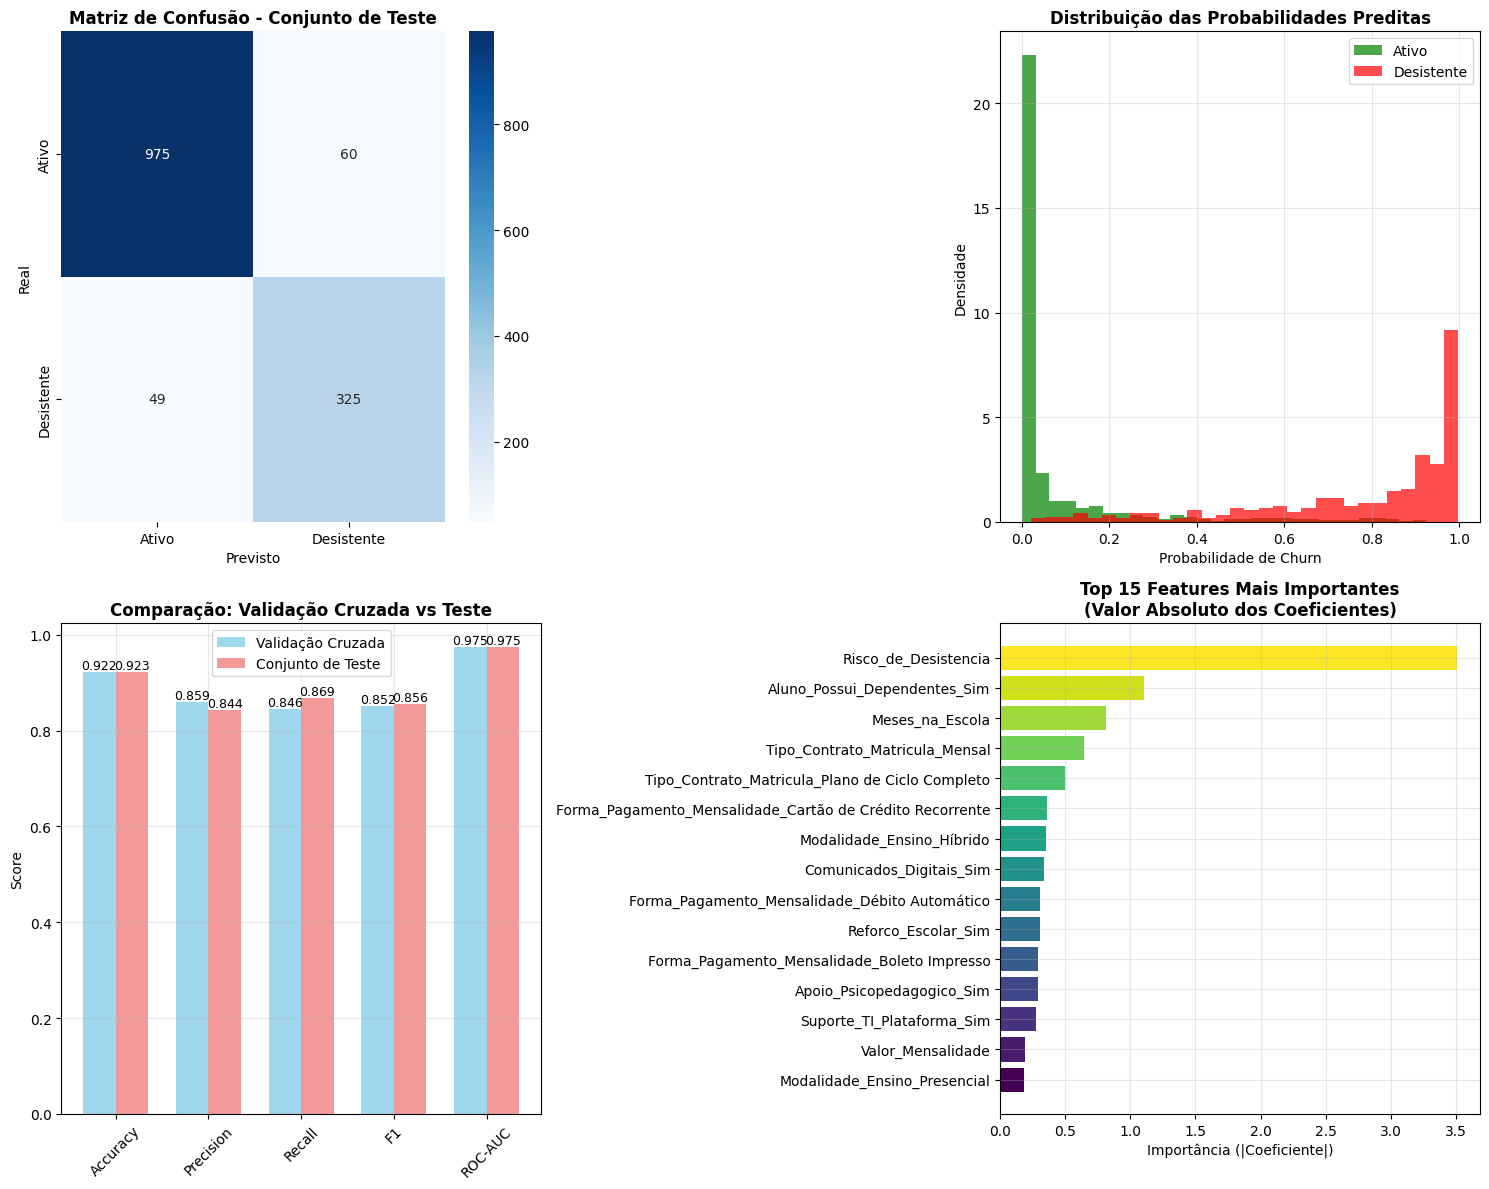


🎯 RESUMO DO MODELO
📊 Modelo: Regressão Logística
🔧 Hiperparâmetros: {'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 0.1}
📈 ROC-AUC (CV): 0.9752 (±0.0018)
🎯 ROC-AUC (Teste): 0.9745
📊 Features utilizadas: 34
📋 Preprocessamento: StandardScaler + OneHotEncoder
⚡ Tunagem: RandomizedSearchCV (20 iterações, 5-fold CV)


In [127]:
# Visualizações
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Matriz de Confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Ativo', 'Desistente'],
            yticklabels=['Ativo', 'Desistente'])
ax1.set_title('Matriz de Confusão - Conjunto de Teste', fontweight='bold')
ax1.set_ylabel('Real')
ax1.set_xlabel('Previsto')

# 2. Distribuição das Probabilidades
ax2.hist(y_pred_proba_test[y_test == 0], bins=30, alpha=0.7, label='Ativo', color='green', density=True)
ax2.hist(y_pred_proba_test[y_test == 1], bins=30, alpha=0.7, label='Desistente', color='red', density=True)
ax2.set_title('Distribuição das Probabilidades Preditas', fontweight='bold')
ax2.set_xlabel('Probabilidade de Churn')
ax2.set_ylabel('Densidade')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Comparação de Métricas (CV vs Teste)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
cv_scores = [cv_results['test_accuracy'].mean(), cv_results['test_precision'].mean(),
             cv_results['test_recall'].mean(), cv_results['test_f1'].mean(),
             cv_results['test_roc_auc'].mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax3.bar(x - width/2, cv_scores, width, label='Validação Cruzada', alpha=0.8, color='skyblue')
bars2 = ax3.bar(x + width/2, test_scores, width, label='Conjunto de Teste', alpha=0.8, color='lightcoral')

ax3.set_title('Comparação: Validação Cruzada vs Teste', fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 4. Importância das Features (Coeficientes da Regressão Logística)
# Obter nomes das features após preprocessamento
feature_names = (numerical_features + 
                list(best_model_lr.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features)))

# Obter coeficientes
coefficients = best_model_lr.named_steps['classifier'].coef_[0]

# Criar DataFrame para ordenação
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefficients)
}).sort_values('importance', ascending=True).tail(15)

ax4.barh(range(len(feature_importance)), feature_importance['importance'], 
         color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance))))
ax4.set_yticks(range(len(feature_importance)))
ax4.set_yticklabels(feature_importance['feature'])
ax4.set_title('Top 15 Features Mais Importantes\n(Valor Absoluto dos Coeficientes)', fontweight='bold')
ax4.set_xlabel('Importância (|Coeficiente|)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumo do modelo
print("\n🎯 RESUMO DO MODELO")
print("=" * 50)
print(f"📊 Modelo: Regressão Logística")
print(f"🔧 Hiperparâmetros: {random_search_lr.best_params_}")
print(f"📈 ROC-AUC (CV): {cv_results['test_roc_auc'].mean():.4f} (±{cv_results['test_roc_auc'].std():.4f})")
print(f"🎯 ROC-AUC (Teste): {test_roc_auc:.4f}")
print(f"📊 Features utilizadas: {len(feature_names)}")
print(f"📋 Preprocessamento: StandardScaler + OneHotEncoder")
print(f"⚡ Tunagem: RandomizedSearchCV (20 iterações, 5-fold CV)")

#### 3.5 Comparação com Outros Modelos (com Tunagem de Hiperparâmetros)

🔄 Comparando modelos com tunagem de hiperparâmetros...

🎯 Tunando Logistic Regression...
✅ Logistic Regression tunado!
   🎯 Melhor ROC-AUC: 0.9752
   📊 CV ROC-AUC: 0.9752 (±0.0018)
   📊 CV F1: 0.8524 (±0.0058)

🎯 Tunando Random Forest...
✅ Logistic Regression tunado!
   🎯 Melhor ROC-AUC: 0.9752
   📊 CV ROC-AUC: 0.9752 (±0.0018)
   📊 CV F1: 0.8524 (±0.0058)

🎯 Tunando Random Forest...
✅ Random Forest tunado!
   🎯 Melhor ROC-AUC: 0.9824
   📊 CV ROC-AUC: 0.9824 (±0.0005)
   📊 CV F1: 0.8746 (±0.0044)

🎯 Tunando Gradient Boosting...
✅ Random Forest tunado!
   🎯 Melhor ROC-AUC: 0.9824
   📊 CV ROC-AUC: 0.9824 (±0.0005)
   📊 CV F1: 0.8746 (±0.0044)

🎯 Tunando Gradient Boosting...
✅ Gradient Boosting tunado!
   🎯 Melhor ROC-AUC: 0.9840
   📊 CV ROC-AUC: 0.9840 (±0.0016)
   📊 CV F1: 0.8750 (±0.0076)

🏆 RESULTADOS FINAIS DA COMPARAÇÃO:
Logistic Regression: ROC-AUC = 0.9752 (±0.0018), F1 = 0.8524 (±0.0058)
     Random Forest: ROC-AUC = 0.9824 (±0.0005), F1 = 0.8746 (±0.0044)
 Gradient Boosting: ROC

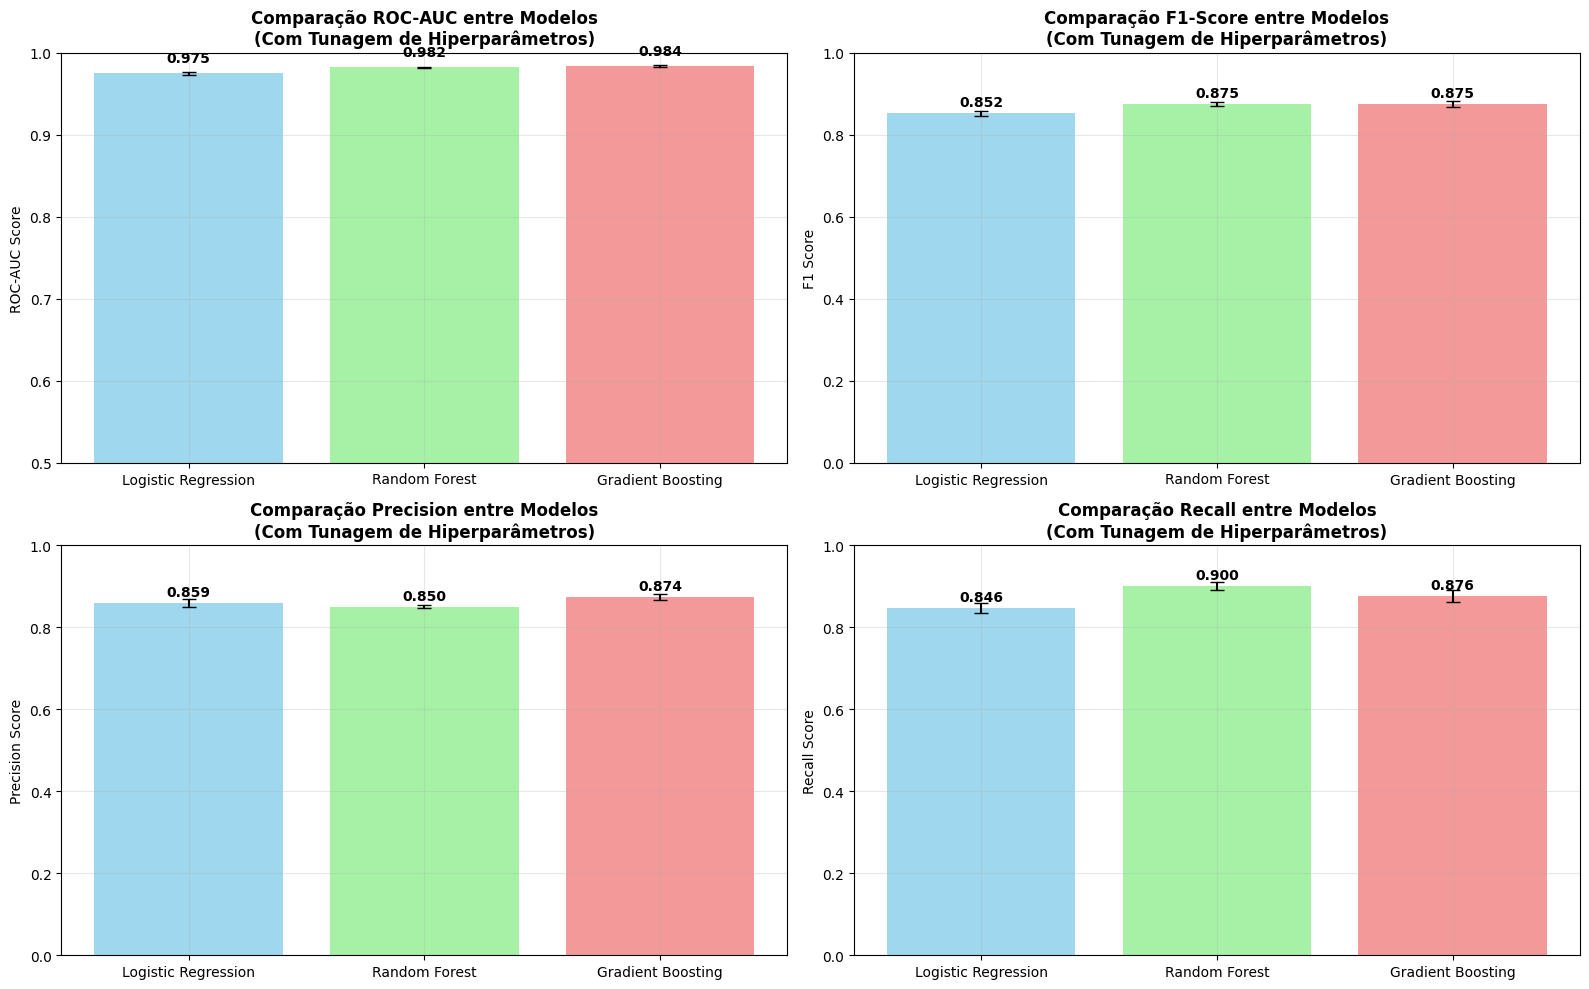


🏆 RANKING DOS MODELOS:
📊 Por ROC-AUC:
   1º Gradient Boosting: 0.9840 (±0.0016)
   2º Random Forest: 0.9824 (±0.0005)
   3º Logistic Regression: 0.9752 (±0.0018)

📊 Por F1-Score:
   1º Gradient Boosting: 0.8750 (±0.0076)
   2º Random Forest: 0.8746 (±0.0044)
   3º Logistic Regression: 0.8524 (±0.0058)

🥇 MODELO VENCEDOR:
   • Melhor ROC-AUC: Gradient Boosting
   • Melhor F1: Gradient Boosting

🔧 MELHORES HIPERPARÂMETROS:

Logistic Regression:
   • solver: saga
   • penalty: l2
   • C: 0.1

Random Forest:
   • n_estimators: 200
   • min_samples_split: 2
   • min_samples_leaf: 1
   • max_features: None
   • max_depth: 5

Gradient Boosting:
   • subsample: 1.0
   • n_estimators: 50
   • min_samples_split: 10
   • min_samples_leaf: 1
   • max_depth: 5
   • learning_rate: 0.1

🎯 AVALIAÇÃO DO MELHOR MODELO NO CONJUNTO DE TESTE:
🏆 MELHOR MODELO: Gradient Boosting
Accuracy:  0.9319
Precision: 0.8528
Recall:    0.8984
F1-Score:  0.8750
ROC-AUC:   0.9822

💡 CONCLUSÃO:
   O Gradient Boosting sup

In [128]:
# Comparação com tunagem de hiperparâmetros para todos os modelos
print("🔄 Comparando modelos com tunagem de hiperparâmetros...")
print("=" * 70)

# Definir modelos e seus espaços de hiperparâmetros
models_config = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear', 'saga']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [3, 5, 10, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': ['sqrt', 'log2', None]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__subsample': [0.8, 0.9, 1.0]
        }
    }
}

results_comparison = {}
best_models = {}

for name, config in models_config.items():
    print(f"\n🎯 Tunando {name}...")
    
    # Criar pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', config['model'])
    ])
    
    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=config['params'],
        n_iter=30,  # Mais iterações para melhor busca
        cv=5,
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    # Treinar
    random_search.fit(X, y)
    
    # Salvar melhor modelo
    best_models[name] = random_search.best_estimator_
    
    # Avaliar com validação cruzada o melhor modelo
    cv_scores = cross_validate(
        random_search.best_estimator_, X, y,
        cv=5,
        scoring=['roc_auc', 'f1', 'precision', 'recall'],
        n_jobs=-1
    )
    
    results_comparison[name] = {
        'ROC-AUC': cv_scores['test_roc_auc'].mean(),
        'ROC-AUC_std': cv_scores['test_roc_auc'].std(),
        'F1': cv_scores['test_f1'].mean(),
        'F1_std': cv_scores['test_f1'].std(),
        'Precision': cv_scores['test_precision'].mean(),
        'Precision_std': cv_scores['test_precision'].std(),
        'Recall': cv_scores['test_recall'].mean(),
        'Recall_std': cv_scores['test_recall'].std(),
        'Best_Score': random_search.best_score_,
        'Best_Params': random_search.best_params_
    }
    
    print(f"✅ {name} tunado!")
    print(f"   🎯 Melhor ROC-AUC: {random_search.best_score_:.4f}")
    print(f"   📊 CV ROC-AUC: {cv_scores['test_roc_auc'].mean():.4f} (±{cv_scores['test_roc_auc'].std():.4f})")
    print(f"   📊 CV F1: {cv_scores['test_f1'].mean():.4f} (±{cv_scores['test_f1'].std():.4f})")

print(f"\n🏆 RESULTADOS FINAIS DA COMPARAÇÃO:")
print("=" * 70)

for name, results in results_comparison.items():
    print(f"{name:>18}: ROC-AUC = {results['ROC-AUC']:.4f} "
          f"(±{results['ROC-AUC_std']:.4f}), "
          f"F1 = {results['F1']:.4f} "
          f"(±{results['F1_std']:.4f})")

# Visualizar comparação detalhada
comparison_df = pd.DataFrame(results_comparison).T

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# 1. ROC-AUC
bars1 = ax1.bar(comparison_df.index, comparison_df['ROC-AUC'], 
                yerr=comparison_df['ROC-AUC_std'], capsize=5, alpha=0.8, 
                color=['skyblue', 'lightgreen', 'lightcoral'])
ax1.set_title('Comparação ROC-AUC entre Modelos\n(Com Tunagem de Hiperparâmetros)', fontweight='bold')
ax1.set_ylabel('ROC-AUC Score')
ax1.set_ylim(0.5, 1.0)
ax1.grid(True, alpha=0.3)

for bar, value in zip(bars1, comparison_df['ROC-AUC']):
    ax1.text(bar.get_x() + bar.get_width()/2., value + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. F1-Score
bars2 = ax2.bar(comparison_df.index, comparison_df['F1'], 
                yerr=comparison_df['F1_std'], capsize=5, alpha=0.8,
                color=['skyblue', 'lightgreen', 'lightcoral'])
ax2.set_title('Comparação F1-Score entre Modelos\n(Com Tunagem de Hiperparâmetros)', fontweight='bold')
ax2.set_ylabel('F1 Score')
ax2.set_ylim(0.0, 1.0)
ax2.grid(True, alpha=0.3)

for bar, value in zip(bars2, comparison_df['F1']):
    ax2.text(bar.get_x() + bar.get_width()/2., value + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Precision
bars3 = ax3.bar(comparison_df.index, comparison_df['Precision'], 
                yerr=comparison_df['Precision_std'], capsize=5, alpha=0.8,
                color=['skyblue', 'lightgreen', 'lightcoral'])
ax3.set_title('Comparação Precision entre Modelos\n(Com Tunagem de Hiperparâmetros)', fontweight='bold')
ax3.set_ylabel('Precision Score')
ax3.set_ylim(0.0, 1.0)
ax3.grid(True, alpha=0.3)

for bar, value in zip(bars3, comparison_df['Precision']):
    ax3.text(bar.get_x() + bar.get_width()/2., value + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Recall
bars4 = ax4.bar(comparison_df.index, comparison_df['Recall'], 
                yerr=comparison_df['Recall_std'], capsize=5, alpha=0.8,
                color=['skyblue', 'lightgreen', 'lightcoral'])
ax4.set_title('Comparação Recall entre Modelos\n(Com Tunagem de Hiperparâmetros)', fontweight='bold')
ax4.set_ylabel('Recall Score')
ax4.set_ylim(0.0, 1.0)
ax4.grid(True, alpha=0.3)

for bar, value in zip(bars4, comparison_df['Recall']):
    ax4.text(bar.get_x() + bar.get_width()/2., value + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Identificar melhor modelo
best_roc_auc_model = comparison_df['ROC-AUC'].idxmax()
best_f1_model = comparison_df['F1'].idxmax()

print(f"\n🏆 RANKING DOS MODELOS:")
print("=" * 50)
print("📊 Por ROC-AUC:")
roc_ranking = comparison_df.sort_values('ROC-AUC', ascending=False)
for i, (model, row) in enumerate(roc_ranking.iterrows(), 1):
    print(f"   {i}º {model}: {row['ROC-AUC']:.4f} (±{row['ROC-AUC_std']:.4f})")

print("\n📊 Por F1-Score:")
f1_ranking = comparison_df.sort_values('F1', ascending=False)
for i, (model, row) in enumerate(f1_ranking.iterrows(), 1):
    print(f"   {i}º {model}: {row['F1']:.4f} (±{row['F1_std']:.4f})")

print(f"\n🥇 MODELO VENCEDOR:")
print(f"   • Melhor ROC-AUC: {best_roc_auc_model}")
print(f"   • Melhor F1: {best_f1_model}")

# Mostrar melhores hiperparâmetros
print(f"\n🔧 MELHORES HIPERPARÂMETROS:")
print("=" * 50)
for model_name, results in results_comparison.items():
    print(f"\n{model_name}:")
    for param, value in results['Best_Params'].items():
        param_clean = param.replace('classifier__', '')
        print(f"   • {param_clean}: {value}")

# Avaliar melhor modelo no conjunto de teste
print(f"\n🎯 AVALIAÇÃO DO MELHOR MODELO NO CONJUNTO DE TESTE:")
print("=" * 60)

best_overall_model = best_models[best_roc_auc_model]

# Fazer predições no conjunto de teste
y_pred_test_best = best_overall_model.predict(X_test)
y_pred_proba_test_best = best_overall_model.predict_proba(X_test)[:, 1]

# Calcular métricas
test_accuracy_best = accuracy_score(y_test, y_pred_test_best)
test_precision_best = precision_score(y_test, y_pred_test_best)
test_recall_best = recall_score(y_test, y_pred_test_best)
test_f1_best = f1_score(y_test, y_pred_test_best)
test_roc_auc_best = roc_auc_score(y_test, y_pred_proba_test_best)

print(f"🏆 MELHOR MODELO: {best_roc_auc_model}")
print(f"Accuracy:  {test_accuracy_best:.4f}")
print(f"Precision: {test_precision_best:.4f}")
print(f"Recall:    {test_recall_best:.4f}")
print(f"F1-Score:  {test_f1_best:.4f}")
print(f"ROC-AUC:   {test_roc_auc_best:.4f}")

print(f"\n💡 CONCLUSÃO:")
if best_roc_auc_model == 'Logistic Regression':
    print("   A Regressão Logística continua sendo o melhor modelo!")
    print("   Isso sugere que o problema tem características lineares.")
else:
    print(f"   O {best_roc_auc_model} superou a Regressão Logística!")
    print("   Vale a pena usar este modelo para produção.")
    
    # Atualizar modelo final se não for Logistic Regression
    print(f"\n🔄 ATUALIZANDO MODELO FINAL PARA: {best_roc_auc_model}")
    best_model_lr = best_overall_model

### 4.0 📊 Tabela Final para Ação Comercial

#### 4.1 Ranking de Alunos por Probabilidade de Churn

In [129]:
# Recarregar dados originais para obter informações completas dos alunos
train_original = pd.read_csv(BASE_FOLDER / TRAIN_FILENAME)
test_original = pd.read_csv(BASE_FOLDER / TEST_FILENAME)

# Combinar treino e teste para análise completa
all_data = pd.concat([train_original, test_original], ignore_index=True)

print(f"📊 Total de alunos na base: {len(all_data)}")
print(f"🎯 Alunos ativos: {len(all_data[all_data['Situacao'] == 'Ativo'])}")
print(f"❌ Alunos já desistentes: {len(all_data[all_data['Situacao'] == 'Desistente'])}")

# Preparar dados completos para predição
all_data_processed = manual_feature_selection(all_data, cols_to_drop=cols_to_drop)
all_data_processed = remove_whitespace(all_data_processed, columns=cols_remove_whitespace)
all_data_processed = convert_string_to_float(all_data_processed, columns=cols_convert_to_float)

X_all = all_data_processed.drop(columns=[TARGET_COLUMN])

# Fazer predições para todos os alunos
y_pred_all = best_model_lr.predict(X_all)
y_pred_proba_all = best_model_lr.predict_proba(X_all)[:, 1]

print(f"\n🤖 Predições geradas para {len(y_pred_proba_all)} alunos")

# Criar tabela final combinando informações originais com predições
final_results = pd.DataFrame({
    'Matricula_Aluno': all_data['Matricula_Aluno'],
    'Situacao_Atual': all_data['Situacao'],
    'Desistencia_Real': all_data['Desistencia'],
    'Probabilidade_Churn': y_pred_proba_all,
    'Predicao_Churn': y_pred_all,
    'Meses_na_Escola': all_data['Meses_na_Escola'],
    'Modalidade_Ensino': all_data['Modalidade_Ensino'],
    'Valor_Mensalidade': all_data['Valor_Mensalidade'],
    'Tipo_Contrato_Matricula': all_data['Tipo_Contrato_Matricula'],
    'Forma_Pagamento_Mensalidade': all_data['Forma_Pagamento_Mensalidade'],
    'Genero': all_data['Genero'],
    'Aluno_Bolsista': all_data['Aluno_Bolsista'],
    'Participa_Atividade_Extra': all_data['Participa_Atividade_Extra'],
    'Apoio_Psicopedagogico': all_data['Apoio_Psicopedagogico'],
    'Reforco_Escolar': all_data['Reforco_Escolar'],
    'Risco_de_Desistencia': all_data['Risco_de_Desistencia']
})

# Adicionar classificação de risco baseada na probabilidade
def classificar_risco(prob):
    if prob >= 0.8:
        return 'CRÍTICO'
    elif prob >= 0.6:
        return 'ALTO'
    elif prob >= 0.4:
        return 'MÉDIO'
    elif prob >= 0.2:
        return 'BAIXO'
    else:
        return 'MUITO BAIXO'

final_results['Nivel_Risco'] = final_results['Probabilidade_Churn'].apply(classificar_risco)

# Ordenar por probabilidade de churn (maior primeiro)
final_results = final_results.sort_values('Probabilidade_Churn', ascending=False).reset_index(drop=True)

print(f"\n📋 Distribuição por Nível de Risco:")
risk_distribution = final_results['Nivel_Risco'].value_counts()
for nivel, count in risk_distribution.items():
    percentage = (count / len(final_results)) * 100
    print(f"   {nivel}: {count} alunos ({percentage:.1f}%)")

# Filtrar apenas alunos ATIVOS para ação comercial
alunos_ativos = final_results[final_results['Situacao_Atual'] == 'Ativo'].copy()
alunos_ativos = alunos_ativos.reset_index(drop=True)
alunos_ativos['Ranking'] = alunos_ativos.index + 1

print(f"\n🎯 FOCO NA AÇÃO COMERCIAL:")
print(f"📞 Alunos ativos para contato: {len(alunos_ativos)}")

# Estatísticas dos alunos ativos por risco
print(f"\n📊 Alunos Ativos por Nível de Risco:")
risk_active = alunos_ativos['Nivel_Risco'].value_counts()
for nivel, count in risk_active.items():
    percentage = (count / len(alunos_ativos)) * 100
    print(f"   {nivel}: {count} alunos ({percentage:.1f}%)")

# Criar tabela prioritária (top riscos)
top_risk_students = alunos_ativos[alunos_ativos['Nivel_Risco'].isin(['CRÍTICO', 'ALTO'])].head(50)

print(f"\n🚨 TOP 50 ALUNOS PRIORITÁRIOS PARA CONTATO:")
print("=" * 80)

📊 Total de alunos na base: 7043
🎯 Alunos ativos: 5174
❌ Alunos já desistentes: 1869

🤖 Predições geradas para 7043 alunos

📋 Distribuição por Nível de Risco:
   MUITO BAIXO: 4715 alunos (66.9%)
   CRÍTICO: 1301 alunos (18.5%)
   ALTO: 388 alunos (5.5%)
   MÉDIO: 356 alunos (5.1%)
   BAIXO: 283 alunos (4.0%)

🎯 FOCO NA AÇÃO COMERCIAL:
📞 Alunos ativos para contato: 5174

📊 Alunos Ativos por Nível de Risco:
   MUITO BAIXO: 4678 alunos (90.4%)
   BAIXO: 202 alunos (3.9%)
   MÉDIO: 181 alunos (3.5%)
   ALTO: 102 alunos (2.0%)
   CRÍTICO: 11 alunos (0.2%)

🚨 TOP 50 ALUNOS PRIORITÁRIOS PARA CONTATO:

🤖 Predições geradas para 7043 alunos

📋 Distribuição por Nível de Risco:
   MUITO BAIXO: 4715 alunos (66.9%)
   CRÍTICO: 1301 alunos (18.5%)
   ALTO: 388 alunos (5.5%)
   MÉDIO: 356 alunos (5.1%)
   BAIXO: 283 alunos (4.0%)

🎯 FOCO NA AÇÃO COMERCIAL:
📞 Alunos ativos para contato: 5174

📊 Alunos Ativos por Nível de Risco:
   MUITO BAIXO: 4678 alunos (90.4%)
   BAIXO: 202 alunos (3.9%)
   MÉDIO: 18

In [130]:
# Exibir tabela prioritária formatada
colunas_display = [
    'Ranking', 'Matricula_Aluno', 'Probabilidade_Churn', 'Nivel_Risco',
    'Meses_na_Escola', 'Modalidade_Ensino', 'Valor_Mensalidade',
    'Tipo_Contrato_Matricula', 'Forma_Pagamento_Mensalidade', 'Genero'
]

tabela_prioritaria = top_risk_students[colunas_display].copy()
tabela_prioritaria['Probabilidade_Churn'] = tabela_prioritaria['Probabilidade_Churn'].round(3)
tabela_prioritaria['Valor_Mensalidade'] = tabela_prioritaria['Valor_Mensalidade'].round(2)

# Exibir as primeiras 20 linhas
print(tabela_prioritaria.head(20).to_string(index=False))

print(f"\n📈 ESTATÍSTICAS DOS TOP 50 ALUNOS PRIORITÁRIOS:")
print("=" * 60)
print(f"💰 Valor médio mensalidade: R$ {top_risk_students['Valor_Mensalidade'].mean():.2f}")
print(f"📅 Permanência média: {top_risk_students['Meses_na_Escola'].mean():.1f} meses")
print(f"🎓 Modalidade mais comum: {top_risk_students['Modalidade_Ensino'].mode().iloc[0]}")
print(f"📋 Contrato mais comum: {top_risk_students['Tipo_Contrato_Matricula'].mode().iloc[0]}")
print(f"💳 Pagamento mais comum: {top_risk_students['Forma_Pagamento_Mensalidade'].mode().iloc[0]}")

# Análise por faixas de tempo críticas
print(f"\n⏰ ANÁLISE POR TEMPO NA ESCOLA (Top 50):")
faixas_tempo = pd.cut(top_risk_students['Meses_na_Escola'], 
                     bins=[0, 3, 6, 12, float('inf')], 
                     labels=['0-3 meses', '4-6 meses', '7-12 meses', '12+ meses'])
tempo_dist = faixas_tempo.value_counts()
for faixa, count in tempo_dist.items():
    percentage = (count / len(top_risk_students)) * 100
    print(f"   {faixa}: {count} alunos ({percentage:.1f}%)")

# Salvar tabela completa para uso da equipe
print(f"\n💾 SALVANDO ARQUIVOS PARA A EQUIPE COMERCIAL:")
print("=" * 50)

# Tabela completa de alunos ativos
output_folder = Path('../data/output')
output_folder.mkdir(exist_ok=True)

# Arquivo 1: Todos os alunos ativos ranqueados
arquivo_completo = output_folder / 'ranking_churn_todos_alunos_ativos.csv'
alunos_ativos.to_csv(arquivo_completo, index=False)
print(f"✅ Arquivo salvo: {arquivo_completo}")
print(f"   📊 {len(alunos_ativos)} alunos ativos ranqueados")

# Arquivo 2: Top 100 alunos prioritários
arquivo_prioritario = output_folder / 'top_100_alunos_prioritarios.csv'
top_100 = alunos_ativos.head(100)
top_100.to_csv(arquivo_prioritario, index=False)
print(f"✅ Arquivo salvo: {arquivo_prioritario}")
print(f"   🎯 Top 100 alunos com maior risco")

# Arquivo 3: Apenas alunos com risco CRÍTICO e ALTO
arquivo_alto_risco = output_folder / 'alunos_risco_critico_alto.csv'
alto_risco = alunos_ativos[alunos_ativos['Nivel_Risco'].isin(['CRÍTICO', 'ALTO'])]
alto_risco.to_csv(arquivo_alto_risco, index=False)
print(f"✅ Arquivo salvo: {arquivo_alto_risco}")
print(f"   🚨 {len(alto_risco)} alunos com risco CRÍTICO/ALTO")

print(f"\n📋 COLUNAS DISPONÍVEIS NOS ARQUIVOS:")
print("=" * 40)
for col in alunos_ativos.columns:
    print(f"   • {col}")

print(f"\n🎯 PRÓXIMOS PASSOS PARA A EQUIPE COMERCIAL:")
print("=" * 50)
print("1. 📞 Priorizar contato com alunos de risco CRÍTICO")
print("2. 🕐 Focar nos primeiros 3-6 meses (período mais crítico)")
print("3. 💰 Atenção especial para contratos mensais")
print("4. 📋 Oferecer serviços de apoio psicopedagógico")
print("5. 💳 Migrar pagamentos para débito automático quando possível")

 Ranking Matricula_Aluno  Probabilidade_Churn Nivel_Risco  Meses_na_Escola Modalidade_Ensino  Valor_Mensalidade Tipo_Contrato_Matricula  Forma_Pagamento_Mensalidade Genero
       1      2545-EBUPK                0.865     CRÍTICO                2           Híbrido              84.05                  Mensal               Boleto Digital Female
       2      9629-NHXFW                0.849     CRÍTICO                1               EAD              19.40                  Mensal              Boleto Impresso Female
       3      4090-KPJIP                0.839     CRÍTICO                3           Híbrido              74.95                  Mensal               Boleto Digital Female
       4      2262-SLNVK                0.835     CRÍTICO                1           Híbrido              70.10                  Mensal               Boleto Digital Female
       5      4445-ZJNMU                0.825     CRÍTICO                9           Híbrido              99.30                  Mensal Cart

#### 4.2 Visualização Final e Resumo Executivo

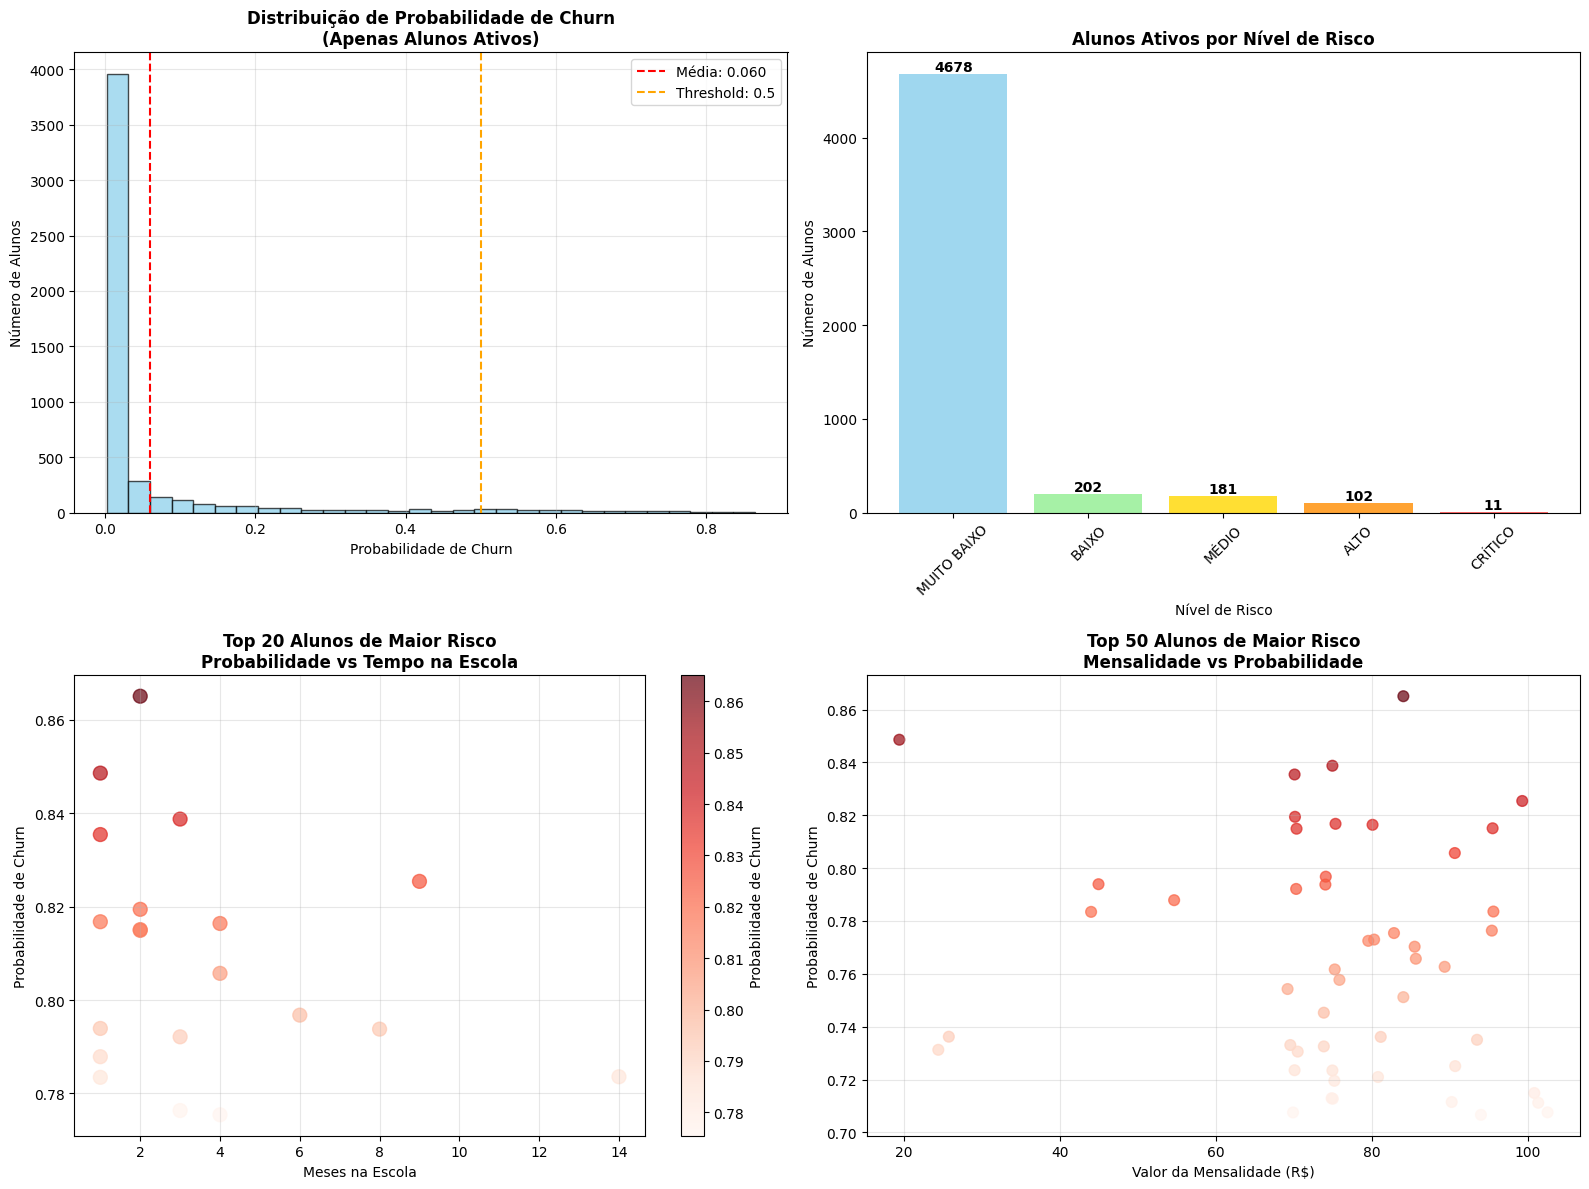


🎯 RESUMO EXECUTIVO - MODELO DE PREDIÇÃO DE CHURN

📊 PERFORMANCE DO MODELO:
   • ROC-AUC: 0.9745
   • Acurácia: 0.9226
   • Precisão: 0.8442
   • Recall: 0.8690
   • F1-Score: 0.8564

📈 SITUAÇÃO ATUAL:
   • Total de alunos ativos: 5,174
   • Alunos em risco CRÍTICO: 11
   • Alunos em risco ALTO: 102
   • Total prioritários (CRÍTICO + ALTO): 113

💰 RECEITA MENSAL EM RISCO:
   • Risco CRÍTICO: R$ 829.90
   • Risco ALTO: R$ 7,908.60
   • Total em risco: R$ 8,738.50

👤 PERFIL DOS ALUNOS DE ALTO RISCO:
   • Permanência média: 10.7 meses
   • Mensalidade média: R$ 77.33
   • Modalidade predominante: Híbrido
   • Contrato predominante: Mensal

📞 AÇÃO IMEDIATA RECOMENDADA:
   • Contatar 113 alunos prioritários
   • Focar nos primeiros 100 do ranking
   • Implementar ações de retenção específicas
   • Monitorar evolução semanal das probabilidades

📁 ARQUIVOS GERADOS:
   • ranking_churn_todos_alunos_ativos.csv (5,174 registros)
   • top_100_alunos_prioritarios.csv (100 registros)
   • alunos_ris

In [131]:
# Visualização final para apresentação
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribuição de Probabilidades de Churn (Apenas Alunos Ativos)
ax1.hist(alunos_ativos['Probabilidade_Churn'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(alunos_ativos['Probabilidade_Churn'].mean(), color='red', linestyle='--', 
           label=f'Média: {alunos_ativos["Probabilidade_Churn"].mean():.3f}')
ax1.axvline(0.5, color='orange', linestyle='--', label='Threshold: 0.5')
ax1.set_title('Distribuição de Probabilidade de Churn\n(Apenas Alunos Ativos)', fontweight='bold')
ax1.set_xlabel('Probabilidade de Churn')
ax1.set_ylabel('Número de Alunos')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Alunos por Nível de Risco
risk_colors = {'CRÍTICO': '#FF4444', 'ALTO': '#FF8C00', 'MÉDIO': '#FFD700', 'BAIXO': '#90EE90', 'MUITO BAIXO': '#87CEEB'}
risk_counts = alunos_ativos['Nivel_Risco'].value_counts()
colors = [risk_colors.get(level, 'gray') for level in risk_counts.index]

bars = ax2.bar(risk_counts.index, risk_counts.values, color=colors, alpha=0.8)
ax2.set_title('Alunos Ativos por Nível de Risco', fontweight='bold')
ax2.set_ylabel('Número de Alunos')
ax2.set_xlabel('Nível de Risco')

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 3. Top 20 Alunos - Probabilidade vs Meses na Escola
top_20 = alunos_ativos.head(20)
scatter = ax3.scatter(top_20['Meses_na_Escola'], top_20['Probabilidade_Churn'], 
                     c=top_20['Probabilidade_Churn'], cmap='Reds', s=100, alpha=0.7)
ax3.set_title('Top 20 Alunos de Maior Risco\nProbabilidade vs Tempo na Escola', fontweight='bold')
ax3.set_xlabel('Meses na Escola')
ax3.set_ylabel('Probabilidade de Churn')
ax3.grid(True, alpha=0.3)

# Adicionar colorbar
plt.colorbar(scatter, ax=ax3, label='Probabilidade de Churn')

# 4. Valor da Mensalidade vs Probabilidade (Top 50)
top_50_viz = alunos_ativos.head(50)
scatter2 = ax4.scatter(top_50_viz['Valor_Mensalidade'], top_50_viz['Probabilidade_Churn'],
                      c=top_50_viz['Probabilidade_Churn'], cmap='Reds', s=60, alpha=0.7)
ax4.set_title('Top 50 Alunos de Maior Risco\nMensalidade vs Probabilidade', fontweight='bold')
ax4.set_xlabel('Valor da Mensalidade (R$)')
ax4.set_ylabel('Probabilidade de Churn')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumo Executivo Final
print("\n" + "="*80)
print("🎯 RESUMO EXECUTIVO - MODELO DE PREDIÇÃO DE CHURN")
print("="*80)

# Métricas do modelo
print(f"\n📊 PERFORMANCE DO MODELO:")
print(f"   • ROC-AUC: {test_roc_auc:.4f}")
print(f"   • Acurácia: {test_accuracy:.4f}")
print(f"   • Precisão: {test_precision:.4f}")
print(f"   • Recall: {test_recall:.4f}")
print(f"   • F1-Score: {test_f1:.4f}")

# Situação atual
print(f"\n📈 SITUAÇÃO ATUAL:")
print(f"   • Total de alunos ativos: {len(alunos_ativos):,}")
print(f"   • Alunos em risco CRÍTICO: {len(alunos_ativos[alunos_ativos['Nivel_Risco'] == 'CRÍTICO']):,}")
print(f"   • Alunos em risco ALTO: {len(alunos_ativos[alunos_ativos['Nivel_Risco'] == 'ALTO']):,}")
print(f"   • Total prioritários (CRÍTICO + ALTO): {len(alto_risco):,}")

# Potencial de receita em risco
receita_risco_critico = alunos_ativos[alunos_ativos['Nivel_Risco'] == 'CRÍTICO']['Valor_Mensalidade'].sum()
receita_risco_alto = alunos_ativos[alunos_ativos['Nivel_Risco'] == 'ALTO']['Valor_Mensalidade'].sum()
receita_total_risco = receita_risco_critico + receita_risco_alto

print(f"\n💰 RECEITA MENSAL EM RISCO:")
print(f"   • Risco CRÍTICO: R$ {receita_risco_critico:,.2f}")
print(f"   • Risco ALTO: R$ {receita_risco_alto:,.2f}")
print(f"   • Total em risco: R$ {receita_total_risco:,.2f}")

# Perfil dos alunos de alto risco
print(f"\n👤 PERFIL DOS ALUNOS DE ALTO RISCO:")
alto_risco_profile = alunos_ativos[alunos_ativos['Nivel_Risco'].isin(['CRÍTICO', 'ALTO'])]
print(f"   • Permanência média: {alto_risco_profile['Meses_na_Escola'].mean():.1f} meses")
print(f"   • Mensalidade média: R$ {alto_risco_profile['Valor_Mensalidade'].mean():.2f}")
print(f"   • Modalidade predominante: {alto_risco_profile['Modalidade_Ensino'].mode().iloc[0]}")
print(f"   • Contrato predominante: {alto_risco_profile['Tipo_Contrato_Matricula'].mode().iloc[0]}")

print(f"\n📞 AÇÃO IMEDIATA RECOMENDADA:")
print(f"   • Contatar {len(alto_risco):,} alunos prioritários")
print(f"   • Focar nos primeiros 100 do ranking")
print(f"   • Implementar ações de retenção específicas")
print(f"   • Monitorar evolução semanal das probabilidades")

print(f"\n📁 ARQUIVOS GERADOS:")
print(f"   • ranking_churn_todos_alunos_ativos.csv ({len(alunos_ativos):,} registros)")
print(f"   • top_100_alunos_prioritarios.csv (100 registros)")
print(f"   • alunos_risco_critico_alto.csv ({len(alto_risco):,} registros)")